# 파이토치 CIFAR10 모델
- 코드 출처: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## modules import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-1-23697d773e56>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


- 현재 GPU 설정

In [2]:
torch.cuda.is_available()

True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
device

device(type='cuda')

## 전처리 설정

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

## 데이터 로드 및 확인

In [6]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform = transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                        train=False,
                                        download=True,
                                        transform = transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49198948.71it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [7]:
train_loader = DataLoader(trainset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(trainset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=2)

In [8]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

car	 frog	 bird	 horse	


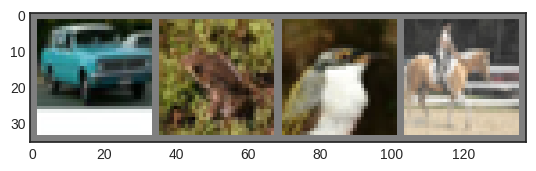

In [9]:
def imshow(img):
  img = img/2+0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('{}\t'.format(classes[labels[j]]) for j in range(4)))

## 신경망 구성

In [15]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net().to(device)


## 손실함수와 옵티마이저

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

## 모델 학습

- 설명을 위해 `epochs=2`로 지정

In [18]:
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i%2000==1999:
      print("Epoch:{}, Batch:{}, Loss:{}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch:1, Batch:2000, Loss:2.20165684401989
Epoch:1, Batch:4000, Loss:1.8899789578318595
Epoch:1, Batch:6000, Loss:1.6984452982246876
Epoch:1, Batch:8000, Loss:1.6021541155725718
Epoch:1, Batch:10000, Loss:1.5384426633417607
Epoch:1, Batch:12000, Loss:1.47003627038002
Epoch:2, Batch:2000, Loss:1.4135438041687012
Epoch:2, Batch:4000, Loss:1.3598481197655201
Epoch:2, Batch:6000, Loss:1.3351436639949679
Epoch:2, Batch:8000, Loss:1.3101722513213754
Epoch:2, Batch:10000, Loss:1.2801423293873668
Epoch:2, Batch:12000, Loss:1.263425397709012


## 모델의 저장 및 로드

In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

	frog 	truck 	truck 	deer


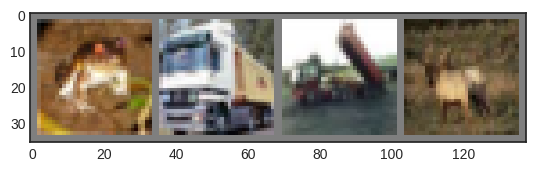

In [21]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [22]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트

In [23]:
outputs = net(images.to(device))

In [24]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	cat 	truck 	truck 	deer


In [25]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100*correct/total)

58.032


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of {}: {}%'.format(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane: 63.12%
Accuracy of car: 72.5%
Accuracy of bird: 53.74%
Accuracy of cat: 45.74%
Accuracy of deer: 46.22%
Accuracy of dog: 40.96%
Accuracy of frog: 55.84%
Accuracy of horse: 65.08%
Accuracy of ship: 69.34%
Accuracy of truck: 67.78%


In [35]:
labels

tensor([6, 9, 1, 1], device='cuda:0')